In [93]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from pylab import savefig

In [342]:
n=12
mask = plt.imread("./{}_gt.png".format(n))
reconstruction = np.load("./{}_reconstruction.npy".format(n))
features = np.load("./{}_features.npy".format(n))

<AxesSubplot:>

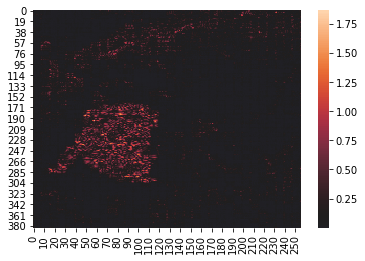

In [345]:
 error = np.abs(features-reconstruction)
error = np.sum(error, axis=-1)
mean = np.mean(error)
sns.heatmap(error, center=mean)

<AxesSubplot:>

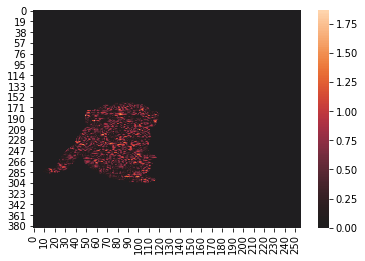

In [346]:
error_true = np.zeros(mask.shape)
n, m = mask.shape
for i in range(n):
    for j in range(m):
        if mask[i, j] == 1:
            error_true[i, j] = error[i, j]
sns.heatmap(error_true, center=np.mean(error_true))

## Cluster

In [348]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import skimage.morphology as morph
from scipy.ndimage.measurements import label

In [349]:
error_list = []
n, m = error.shape
for i in range(n):
    for j in range(m):
        error_list.append([error[i, j]])

In [350]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(error_list)

In [351]:
counts = [0, 0, 0, 0, 0]
for e in kmeans.labels_:
    counts[e] += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


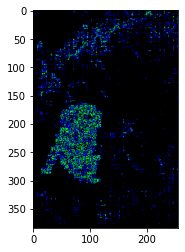

In [352]:
error_2 = np.zeros((n, m, 3))
count = 0
for i in range(n):
    for j in range(m):
        classe = kmeans.labels_[count]
        if classe != np.argmax(counts):
            if classe == 2:
                error_2[i,j] = [255, 0, 0]
            elif classe == 3:
                error_2[i,j] = [0, 255, 0]
            elif classe == 4:
                error_2[i,j] = [0, 0, 255]
            elif classe == 5:
                error_2[i,j] = [255, 255, 255]
        count += 1
plt.imshow(error_2)

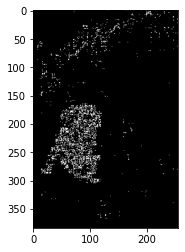

In [353]:
error_2 = np.zeros((n, m))
count = 0
for i in range(n):
    for j in range(m):
        classe = kmeans.labels_[count]
        if classe != np.argmax(counts):
            if classe == 2:
                error_2[i,j] = 1
            elif classe == 3:
                error_2[i,j] = 1
            
        count += 1
plt.imshow(error_2, "gray")

In [251]:
labeled_array, num_features = label(error_2)

In [252]:
count = [0 for _ in range(num_features)]
for i in range(n):
    for j in range(m):
        lab = labeled_array[i, j]
        if lab != 0:
            count[lab - 1] += 1

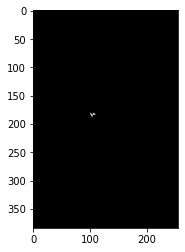

In [253]:
error_final = np.zeros(error.shape)
for i in range(n):
    for j in range(m):
        if labeled_array[i, j] == np.argmax(count) + 1:
            error_final[i, j] = 1
plt.imshow(error_final, "gray")

## Morphologie

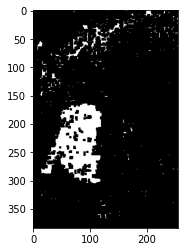

In [354]:
closing = morph.binary_closing(error_2, morph.square(4))
plt.imshow(closing, "gray")

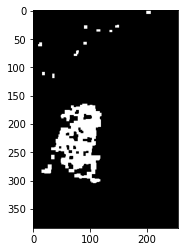

In [355]:
opening = morph.binary_opening(closing, morph.square(4))
plt.imshow(opening, "gray")

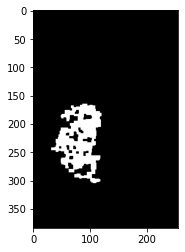

In [356]:
labeled_array, num_features = label(opening)

count = [0 for _ in range(num_features)]
for i in range(n):
    for j in range(m):
        lab = labeled_array[i, j]
        if lab != 0:
            count[lab - 1] += 1

error_final = np.zeros(error.shape)
for i in range(n):
    for j in range(m):
        if labeled_array[i, j] == np.argmax(count) + 1:
            error_final[i, j] = 1
plt.imshow(error_final, "gray")           

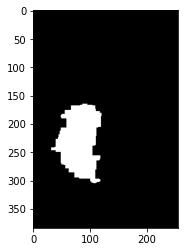

In [357]:
closing_2 = morph.binary_closing(error_final, morph.square(15))
plt.imshow(closing_2, "gray")

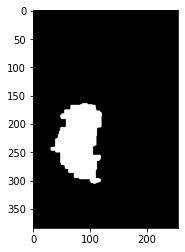

In [358]:
dilatation = morph.binary_dilation(closing_2)
plt.imshow(dilatation, "gray")

## Otsu

In [ ]:
error = error / np.max(error)
error = np.array(error*255, dtype='int32')
n, m = error.shape
sigmax = 0

for threshold in range(1, 256):
    prob1, prob2 = 0, 0
    mean1, mean2 = 0, 0
    for i in range(n):
        for j in range(m):
            if error[i, j] < threshold:
                prob1 += 1
                mean1 += error[i, j]
            else:
                prob2 += 1
                mean2 += error[i, j]
    mean1 = mean1 / prob1
    mean2 = mean2 / prob2
    prob1 = prob1 / (prob2 + prob1)
    prob2 = prob2 / (prob2 + prob1)
    
    sig = prob1 * prob2 * (mean1-mean2)**2
    if sig > sigmax:
        sigmax = sig
        threshmax = threshold

In [ ]:
mask = np.zeros(error.shape)
for i in range(n):
    for j in range(m):
        if error[i, j] > threshmax:
            mask[i, j] = 255

In [ ]:
plt.imshow(mask, 'gray')

## PCA

In [ ]:
error = np.abs(features-reconstruction)
auth = error[80:112, 110:142, :]
auth_lst = []
X, Y, Z = [], [], []
for i in range(32):
    for j in range(32):
        X.append(auth[i, j, 0])
        Y.append(auth[i, j, 1])
        Z.append(auth[i, j, 2])
        auth_lst.append(auth[i, j, :])

In [ ]:
tamp = error[182:214, 255:287, :]
Xtamp, Ytamp, Ztamp = [], [], []
tamp_lst = []
for i in range(32):
    for j in range(32):
        Xtamp.append(tamp[i, j, 0])
        Ytamp.append(tamp[i, j, 1])
        Ztamp.append(tamp[i, j, 2])
        tamp_lst.append(tamp[i, j, :])

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(Xtamp, Ytamp, Ztamp, cmap='blue')
ax.scatter3D(X, Y, Z, cmap='red')

In [ ]:
auth = error[80:112, 208:240, :]
X, Y, Z = [], [], []
for i in range(32):
    for j in range(32):
        X.append(auth[i, j, 0])
        Y.append(auth[i, j, 1])
        Z.append(auth[i, j, 2])
        
tamp = error[208:240, 255:287, :]
Xtamp, Ytamp, Ztamp = [], [], []
for i in range(32):
    for j in range(32):
        Xtamp.append(tamp[i, j, 0])
        Ytamp.append(tamp[i, j, 1])
        Ztamp.append(tamp[i, j, 2])
        
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(Xtamp, Ytamp, Ztamp, cmap='blue')
ax.scatter3D(X, Y, Z, cmap='red')

In [ ]:
n, m = mask.shape
lst_comp = []
X_tamp, Y_tamp, Z_tamp = [], [], []
X_ori, Y_ori, Z_ori = [], [], []
for i in range(n):
    for j in range(m):
        if mask[i, j] == 1:
            X_tamp.append(error[i, j, 0])
            Y_tamp.append(error[i, j, 1])
            Z_tamp.append(error[i, j, 2])
        else:
            X_ori.append(error[i, j, 0])
            Y_ori.append(error[i, j, 1])
            Z_ori.append(error[i, j, 2])
        lst_comp.append(error[i, j, :])      

In [ ]:
pca_glob = PCA(n_components=3)
lst_comp_pca = pca_glob.fit_transform(lst_comp)

pca_auth = PCA(n_components=3)
auth_pca = pca_auth.fit_transform(auth_lst)

pca_tamp = PCA(n_components=3)
tamp_pca = pca_tamp.fit_transform(tamp_lst)

In [ ]:
lst_comp_1 = [e[0] for e in lst_comp_pca]
auth_pca_1 = [e[0] for e in auth_pca]
tamp_pca_1 = [e[0] for e in tamp_pca]

In [ ]:
%matplotlib inline

plt.hist(lst_comp_1, density=True, bins=50)

In [ ]:
plt.hist(tamp_pca_1, density=True, bins=100)

In [ ]:
plt.hist(auth_pca_1, density=True, bins=100)